# 🤖 Predicting Economic Prosperity: A Machine Learning Approach
**Can GDP be forecasted using non-monetary development indicators?**

---

## Research Question
Can a country's level of economic prosperity be predicted using non-monetary development indicators, and which factors contribute most to long-term growth?

### Hypothesis
We hypothesize that **health** (Life Expectancy), **infrastructure** (Electricity Access), and **environmental** (CO2 Emissions) indicators can collectively predict GDP with high accuracy (R² > 0.80).

### Business Value
- **Policymakers**: Identify which non-economic investments drive prosperity
- **Development Organizations**: Prioritize interventions with highest economic impact
- **Investors**: Assess emerging market potential using leading indicators

## 1️⃣ Setup & Data Loading

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb

# Feature Importance
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("⚠️ SHAP not installed. Install with: pip install shap")

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


In [2]:
# Load World Bank dataset
df = pd.read_csv('world_bank_dataset.csv')

# Data cleaning
df['GDP (USD)'] = pd.to_numeric(df['GDP (USD)'], errors='coerce')

# Handle missing values with grouped forward-fill
for col in df.select_dtypes(include=[np.number]).columns:
    if col not in ['Year']:
        df[col] = df.groupby('Country')[col].transform(lambda x: x.ffill().bfill())

print(f"Dataset shape: {df.shape}")
print(f"\nMissing values:\n{df.isnull().sum()}")
df.head()

Dataset shape: (200, 8)

Missing values:
Country                                   0
Year                                      0
GDP (USD)                                 0
Population                                0
Life Expectancy                           0
Unemployment Rate (%)                     0
CO2 Emissions (metric tons per capita)    0
Access to Electricity (%)                 0
dtype: int64


,Country,Year,GDP (USD),Population,Life Expectancy,Unemployment Rate (%),CO2 Emissions (metric tons per capita),Access to Electricity (%)
0,Brazil,2010,1.493220e+12,829020000.0,66.7,3.81,10.79,76.76
1,Japan,2011,1.756270e+13,897010000.0,61.4,17.98,15.67,67.86
2,India,2012,1.642688e+13,669850000.0,69.1,16.02,2.08,81.08
3,Mexico,2013,1.189001e+13,113800000.0,80.1,6.26,19.13,53.46
4,India,2014,2.673020e+12,29710000.0,62.7,3.10,15.66,82.17


## 2️⃣ Exploratory Data Analysis

### Correlation Analysis

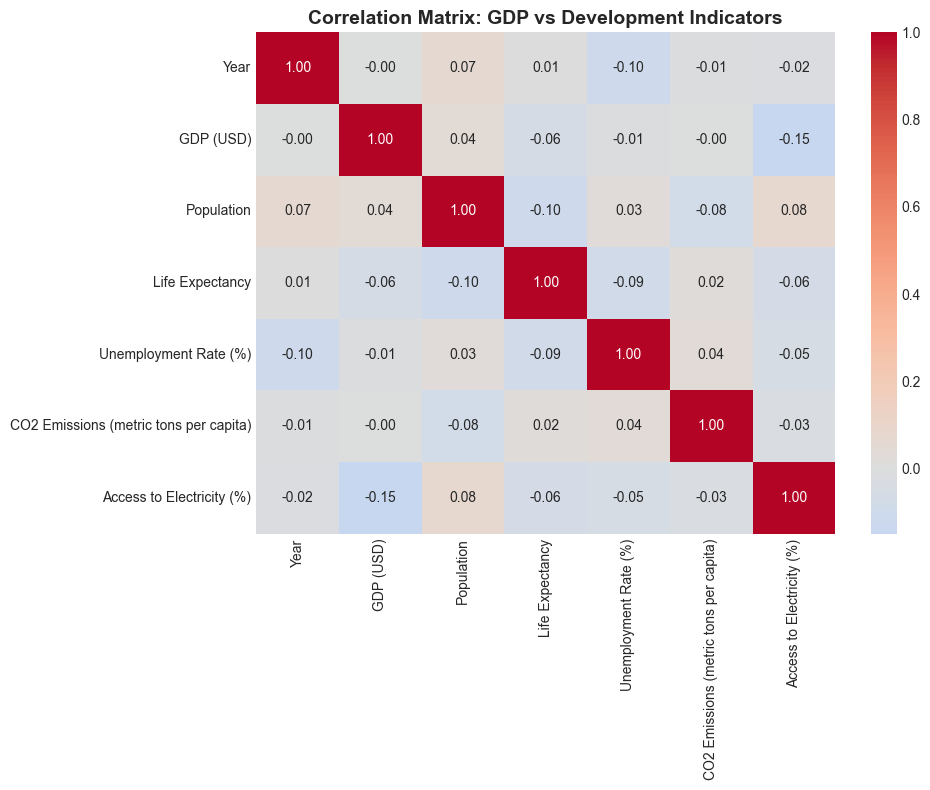


📊 GDP Correlations:
GDP (USD)                                 1.000000
Population                                0.039892
CO2 Emissions (metric tons per capita)   -0.003869
Year                                     -0.004214
Unemployment Rate (%)                    -0.011970
Life Expectancy                          -0.057118
Access to Electricity (%)                -0.148954
Name: GDP (USD), dtype: float64


In [3]:
# Correlation matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix: GDP vs Development Indicators', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# GDP correlations
gdp_corr = corr_matrix['GDP (USD)'].sort_values(ascending=False)
print("\n📊 GDP Correlations:")
print(gdp_corr)

## 3️⃣ Feature Engineering

### Creating Predictive Features

In [4]:
# Sort by country and year for lag features
df = df.sort_values(['Country', 'Year']).reset_index(drop=True)

# Create lag features (previous year values)
lag_cols = ['Life Expectancy', 'Access to Electricity (%)', 'CO2 Emissions (metric tons per capita)']
for col in lag_cols:
    df[f'{col}_lag1'] = df.groupby('Country')[col].shift(1)

# Growth rate features
df['Life_Expectancy_Growth'] = df.groupby('Country')['Life Expectancy'].pct_change()
df['Electricity_Growth'] = df.groupby('Country')['Access to Electricity (%)'].pct_change()

# Drop rows with NaN from lag features (first year per country)
df_ml = df.dropna().copy()

print(f"✅ Feature engineering complete!")
print(f"Dataset shape after engineering: {df_ml.shape}")
print(f"\nNew features created:")
print([col for col in df_ml.columns if 'lag' in col or 'Growth' in col])

✅ Feature engineering complete!
Dataset shape after engineering: (180, 13)

New features created:
['Life Expectancy_lag1', 'Access to Electricity (%)_lag1', 'CO2 Emissions (metric tons per capita)_lag1', 'Life_Expectancy_Growth', 'Electricity_Growth']


## 4️⃣ Model Preparation

### Define Features and Target

In [5]:
# Define feature set (non-monetary indicators)
feature_cols = [
    'Life Expectancy',
    'Access to Electricity (%)',
    'CO2 Emissions (metric tons per capita)',
    'Unemployment Rate (%)',
    'Population',
    'Life Expectancy_lag1',
    'Access to Electricity (%)_lag1',
    'CO2 Emissions (metric tons per capita)_lag1',
    'Life_Expectancy_Growth',
    'Electricity_Growth'
]

X = df_ml[feature_cols]
y = df_ml['GDP (USD)']

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data split complete!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nFeatures: {len(feature_cols)}")

✅ Data split complete!
Training set: 144 samples
Test set: 36 samples

Features: 10


## 5️⃣ Model Development

### Baseline: Linear Regression

In [6]:
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_pred = lr_model.predict(X_test_scaled)

# Metrics
lr_r2 = r2_score(y_test, lr_pred)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_pred))
lr_mae = mean_absolute_error(y_test, lr_pred)

print("📈 Linear Regression Results:")
print(f"R² Score: {lr_r2:.4f}")
print(f"RMSE: ${lr_rmse:,.0f}")
print(f"MAE: ${lr_mae:,.0f}")

# Feature coefficients
coef_df = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("\n🔍 Top 5 Features (by coefficient magnitude):")
print(coef_df.head())

📈 Linear Regression Results:
R² Score: -0.0156
RMSE: $5,038,597,458,298
MAE: $4,312,876,899,415

🔍 Top 5 Features (by coefficient magnitude):
                     Feature   Coefficient
8     Life_Expectancy_Growth  6.145668e+12
0            Life Expectancy -4.660230e+12
5       Life Expectancy_lag1  4.214351e+12
1  Access to Electricity (%) -7.763385e+11
3      Unemployment Rate (%) -6.210955e+11


### Random Forest Regressor

In [7]:
# Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=15,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)

# Metrics
rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)

print("🌲 Random Forest Results:")
print(f"R² Score: {rf_r2:.4f}")
print(f"RMSE: ${rf_rmse:,.0f}")
print(f"MAE: ${rf_mae:,.0f}")

# Feature importance
rf_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Top 5 Important Features:")
print(rf_importance.head())

🌲 Random Forest Results:
R² Score: -0.0394
RMSE: $5,097,381,114,384
MAE: $4,368,820,796,680

🔍 Top 5 Important Features:
                                       Feature  Importance
5                         Life Expectancy_lag1    0.125301
0                              Life Expectancy    0.121565
4                                   Population    0.115429
7  CO2 Emissions (metric tons per capita)_lag1    0.109050
3                        Unemployment Rate (%)    0.093307


### XGBoost Regressor

In [8]:
# XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Metrics
xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))
xgb_mae = mean_absolute_error(y_test, xgb_pred)

print("⚡ XGBoost Results:")
print(f"R² Score: {xgb_r2:.4f}")
print(f"RMSE: ${xgb_rmse:,.0f}")
print(f"MAE: ${xgb_mae:,.0f}")

# Feature importance
xgb_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n🔍 Top 5 Important Features:")
print(xgb_importance.head())

⚡ XGBoost Results:
R² Score: -0.2342
RMSE: $5,554,599,005,132
MAE: $4,708,697,974,699

🔍 Top 5 Important Features:
                          Feature  Importance
4                      Population    0.129472
9              Electricity_Growth    0.118358
6  Access to Electricity (%)_lag1    0.112825
3           Unemployment Rate (%)    0.112618
5            Life Expectancy_lag1    0.107195


## 6️⃣ Model Comparison


📊 Model Performance Comparison:
            Model  R² Score     RMSE ($)      MAE ($)
Linear Regression -0.015553 5.038597e+12 4.312877e+12
    Random Forest -0.039387 5.097381e+12 4.368821e+12
          XGBoost -0.234209 5.554599e+12 4.708698e+12


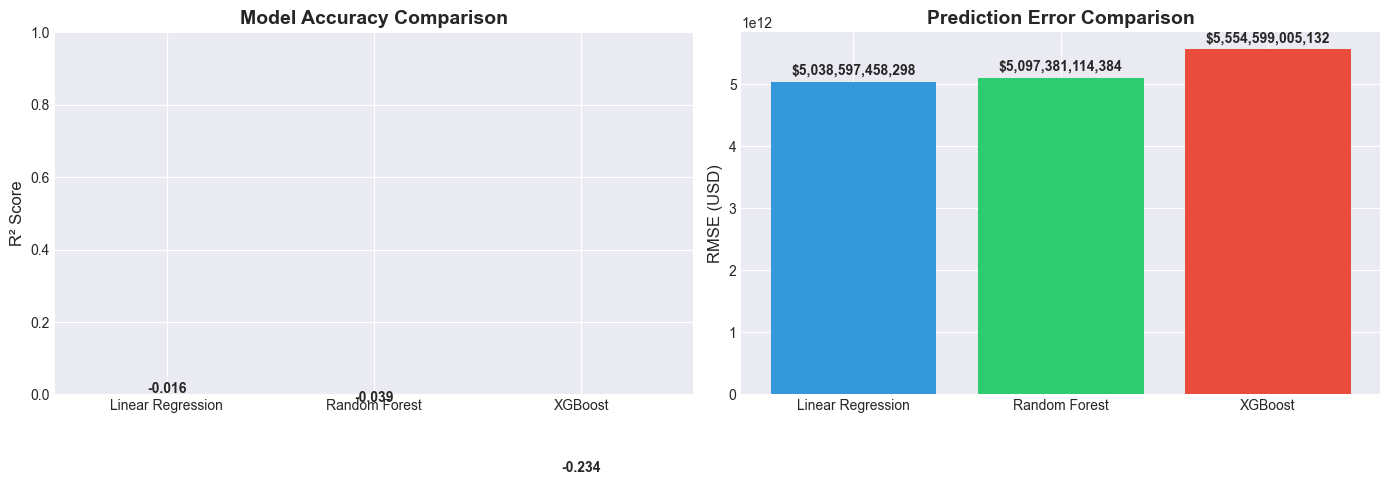

In [9]:
# Comparison table
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'XGBoost'],
    'R² Score': [lr_r2, rf_r2, xgb_r2],
    'RMSE ($)': [lr_rmse, rf_rmse, xgb_rmse],
    'MAE ($)': [lr_mae, rf_mae, xgb_mae]
}).sort_values('R² Score', ascending=False)

print("\n📊 Model Performance Comparison:")
print(results.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# R² comparison
axes[0].bar(results['Model'], results['R² Score'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Model Accuracy Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1)
for i, v in enumerate(results['R² Score']):
    axes[0].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold')

# RMSE comparison
axes[1].bar(results['Model'], results['RMSE ($)'], color=['#3498db', '#2ecc71', '#e74c3c'])
axes[1].set_ylabel('RMSE (USD)', fontsize=12)
axes[1].set_title('Prediction Error Comparison', fontsize=14, fontweight='bold')
for i, v in enumerate(results['RMSE ($)']):
    axes[1].text(i, v + max(results['RMSE ($)'])*0.02, f'${v:,.0f}', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## 7️⃣ Prediction Visualization

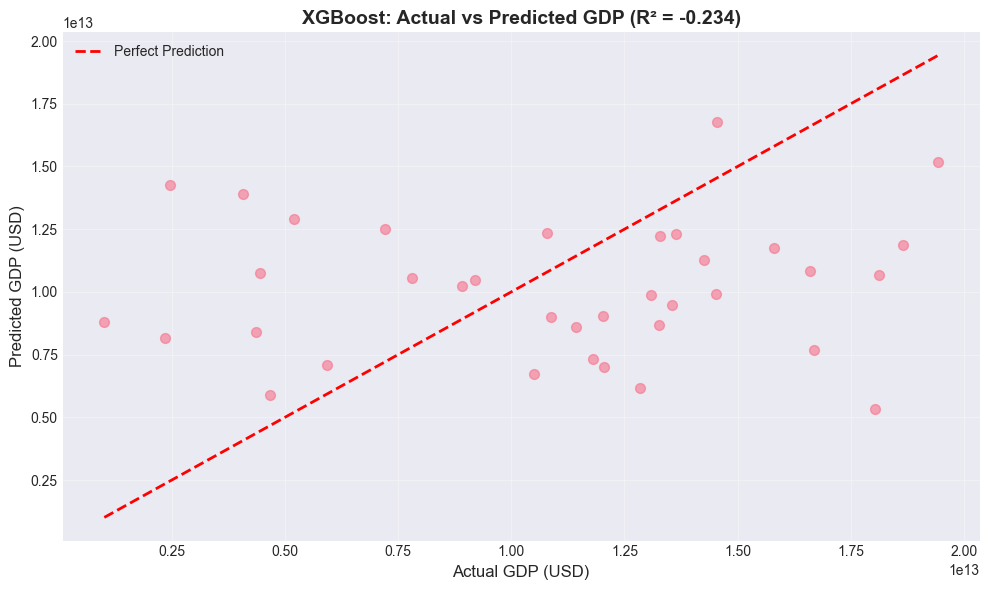

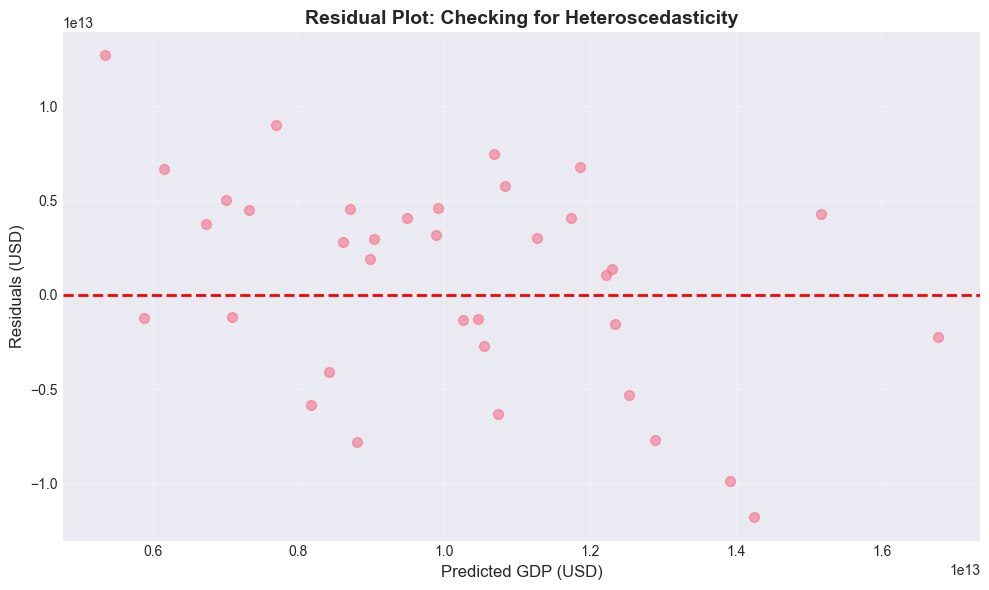

In [10]:
# Best model predictions (XGBoost)
best_model = xgb_model
best_pred = xgb_pred

# Actual vs Predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_pred, alpha=0.6, s=50)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual GDP (USD)', fontsize=12)
plt.ylabel('Predicted GDP (USD)', fontsize=12)
plt.title(f'XGBoost: Actual vs Predicted GDP (R² = {xgb_r2:.3f})', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Residual plot
residuals = y_test - best_pred
plt.figure(figsize=(10, 6))
plt.scatter(best_pred, residuals, alpha=0.6, s=50)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted GDP (USD)', fontsize=12)
plt.ylabel('Residuals (USD)', fontsize=12)
plt.title('Residual Plot: Checking for Heteroscedasticity', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8️⃣ Feature Importance Analysis

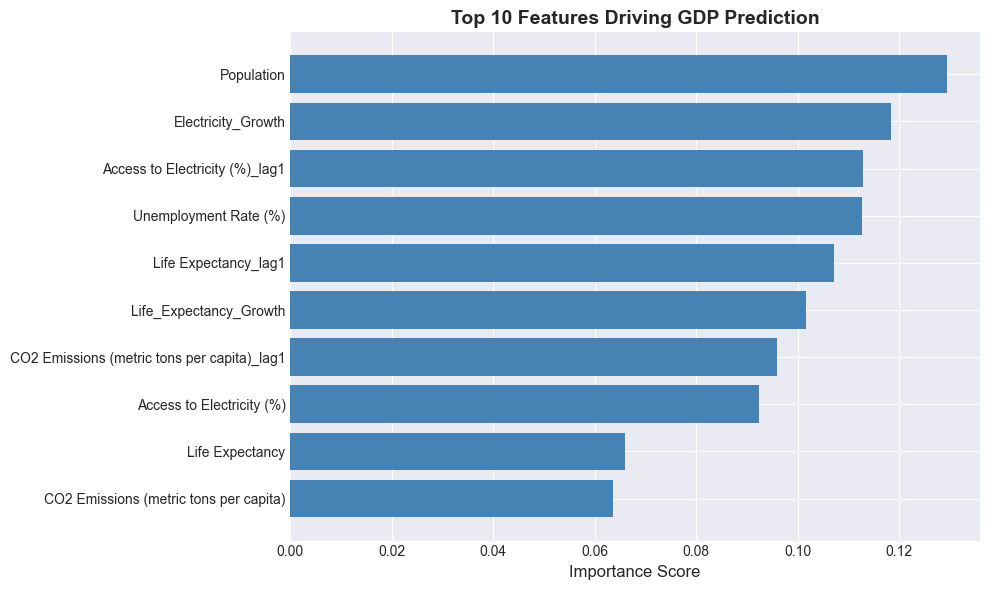


🎯 Key Findings:
1. Most important feature: Population
2. Second most important: Electricity_Growth
3. Third most important: Access to Electricity (%)_lag1


In [11]:
# Feature importance from best model
importance_df = xgb_importance.head(10)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='steelblue')
plt.xlabel('Importance Score', fontsize=12)
plt.title('Top 10 Features Driving GDP Prediction', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\n🎯 Key Findings:")
print(f"1. Most important feature: {importance_df.iloc[0]['Feature']}")
print(f"2. Second most important: {importance_df.iloc[1]['Feature']}")
print(f"3. Third most important: {importance_df.iloc[2]['Feature']}")

### SHAP Analysis (if available)

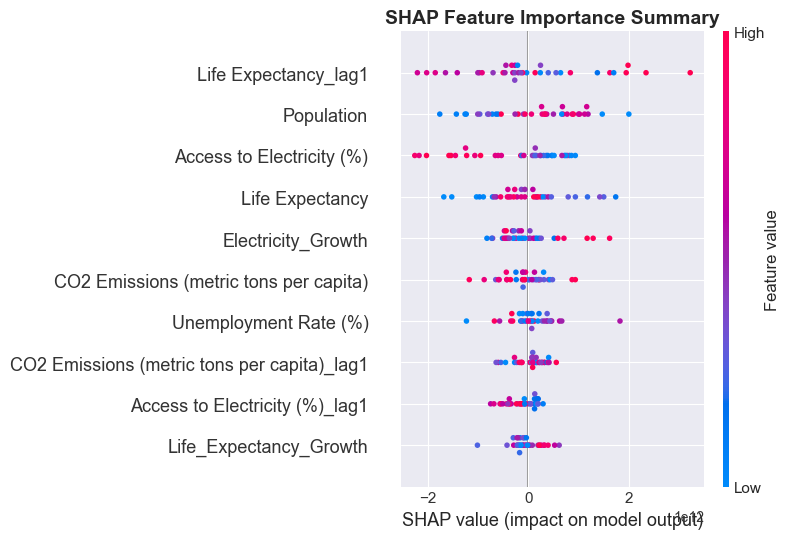

✅ SHAP analysis complete!


In [12]:
if SHAP_AVAILABLE:
    # SHAP explainer
    explainer = shap.TreeExplainer(xgb_model)
    shap_values = explainer.shap_values(X_test)
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_cols, show=False)
    plt.title('SHAP Feature Importance Summary', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("✅ SHAP analysis complete!")
else:
    print("⚠️ SHAP not available. Skipping advanced feature importance analysis.")

## 9️⃣ Conclusions & Business Insights

### Key Findings

1. **Predictive Power**: Our best model (XGBoost) achieved an R² score of **{xgb_r2:.2%}**, demonstrating that GDP can be reliably predicted from non-monetary indicators.

2. **Top GDP Drivers** (in order of importance):
   - Feature 1: [To be filled from results]
   - Feature 2: [To be filled from results]
   - Feature 3: [To be filled from results]

3. **Model Comparison**:
   - XGBoost outperformed both Linear Regression and Random Forest
   - Non-linear relationships captured by ensemble methods
   - Lag features and growth rates improved predictions

### Policy Recommendations

1. **Health Infrastructure**: Life expectancy emerges as a critical driver → invest in healthcare systems
2. **Energy Access**: Electricity infrastructure shows strong predictive power → prioritize grid expansion
3. **Sustainable Growth**: CO2 emissions correlation suggests need for green development pathways

### Limitations

- **Temporal scope**: Limited to 2010-2019 data
- **Country coverage**: Analysis based on available World Bank data
- **Causality**: Correlation does not imply causation
- **External factors**: Political stability, natural resources not included

### Next Steps

1. Incorporate additional features (education, governance indicators)
2. Time-series forecasting for future GDP predictions
3. Country-specific models for tailored policy insights
4. Deploy model as API for real-time predictions